to do:
    - check the name of files, some is _Sort.root some is FINAL.root 
    - spectrum for Jp
    - some files are in the making:
        - Co60 for: Copper Top Ring, Copper Field Shaper, Teflon_Pillar_. PmtTpc, BellPlate
        - U238 for Copper Field Guards,
        - Ra 226 for OuterCryo 
    - plot like Fig.2 here ( https://arxiv.org/pdf/1512.07501.pdf) 
    - why is the rate so high?

In [77]:
%run 'init.ipynb'
%run 'geometry_checks.ipynb'
%run 'functions.ipynb'

from multiprocessing import Pool
from multiprocessing import Process, Value, Array
print("done!")

done!


In [98]:
#list of components and isotopes available.

components = ["PmtTpc",
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "OuterCryostatReflector",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "Teflon_Pillar_",
             "SS_AnodeRing",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
              "Copper_TopRing",
             "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Copper_BottomPmtPlate"
             ]

isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]
#nb ra226 avaialble for everythign but the outer cryo, ongoing sim 

In [125]:
N = 100000000 #events generated in the root stage
m_fv = 4 #tons

#some files are corrupted, therefore we exclude them 

def number_of_events(material):
    N = 100000000
    if material == "SS_OuterCryostat":
        n = {
        'U238' :N-3000 ,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : 999*100000, 
        'Th232' : N,    
        'U235' : N,
        'Ra226' : N,
        }
    if material == "SS_InnerCryostat":
        n = {
        'U238' :N ,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'Th232' : N,
        'U235' : N,
        'Ra226' : N,
        }
    if material == "OuterCryostatReflector":
        n = {
        'U238' :N-3000 ,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N-1000, 
        'U235' : N,
        'Th232' : N-2000,
        'Ra226' : N,
        }  
    if material == "SS_BellPlate":
        n = {
        'U238' :N ,
        'Co60' : N-2000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }   
    if material == "SS_BellSideWall":
        n = {
        'U238' :N ,
        'Co60' : 990*100000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }  
    if material ==  "Teflon_TPC":
        n = {
        'U238' :N ,
        'Co60' : N -1000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }  
    if (  (material == "Teflon_Pillar_") 
                                       | (material == "PmtTpc")          |(material == "SS_AnodeRing")     
                                       |( material =="Teflon_BottomTPC") 
                                       | (material == "Copper_TopRing")  |(material ==  "Copper_TopRing") 
                                       | (material =="Copper_TopRing")   |  (material == "Copper_FieldGuard_") 
                                       | (material == "Copper_FieldShaperRing_" ) | (material == "Copper_BottomPmtPlate")
                                       ):
        n = {
        'U238' :N,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }  
    
    return n



In [44]:
#apply cuts to the dataframe: single scatter, fv, and evergy ROI. If evergy ROI is empty, extend it to 0-100 and re-normalize.
#assume the spectrum is flat 
def calculate_events(data, isotope):
    events_passing = 0
    ss = single_scatter(data)
    fv_ = fv(ss)
    energy_ = energy(fv_, 1, 12)
    events_passing = len(energy_)
    if events_passing == 0:
        en_enlarged = energy(fv_, 1, 100)
        if len(en_enlarged)!= 0:
            events_passing = (len(en_enlarged)*11)/99
        if len(en_enlarged) == 0:
            events_passing = 2.3
            return events_passing
        else:
            return events_passing
    else:
        return events_passing


In [46]:
#function to read the root file in chuncks 
def get_xyz(rootfile):
    dataframe = []
    for df in read_root(rootfile, "events/events", chunksize=1000000,
                             columns= ["xpri", "ypri", "zpri", "epri", "ns", "X", "Y", "Z", "Ed"],
                             where="ns==1"
                            ):#, unit = "chunks"):
        #print(df.X)
        x_values=[x[0] for x in df.X]
        y_values=[y[0] for y in df.Y]
        z_values=[z[0] for z in df.Z]
        df["X"]=x_values
        df["Y"]=y_values
        df["Z"]=z_values
        dataframe.append(df)
    
    dataframe=pd.concat(dataframe)
    dataframe.columns = ['xp', 'yp', 'zp_uc', "epri", "ns", "X", "Y", "Z_uc", "Ed"] #rename 
    offset = 1488/2
    dataframe['rp'] = np.sqrt(dataframe.xp**2+ dataframe.yp**2)
    dataframe['r2p'] = dataframe.rp*dataframe.rp
    dataframe['R'] = np.sqrt(dataframe.X**2+ dataframe.Y**2)
    dataframe['R2'] = (dataframe.R*dataframe.R)
    dataframe['Z'] = dataframe.Z_uc+offset
    dataframe['zp'] = dataframe.zp_uc+ offset
    return dataframe




In [36]:
#test cell for nSort
material = "SS_OuterCryostat"
isotope_array = [#"U238",
                #"Co60",
                #"K40",
                #"Cs137",
                #"Th228",
                #"U235",
                #"Th232",
                "Ra226"
                ]
for isotope in isotope_array:
    rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
    data = get_xyz(rootfile)
    print(isotope, max(data.R))

Ra226 479.24988280101223


In [100]:
def get_data(isotope, component):
    N = 100000000
    #return the correct root file to load according to the component
    df = pd.DataFrame()
    if component == "OuterCryostatShell":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        df = shell
        frac = fraction_shell 
    elif component == "OuterCryostat_Elongation":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        df = elongation
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        frac = fraction_elong 
    elif component == "OuterCryostat_flanges":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        flanges = pd.concat([flange1, flange2, flange3])
        df = flanges
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        frac = fraction_flanges
    elif component == "SS_InnerCryostatShell":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        df = shell_in
        frac = fraction_shell
    elif component == "SS_InnerCryostatFlanges":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        df = flanges_in
        frac = fraction_flanges
    elif component == "SS_InnerCryostat_bottomDome":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        frac = fraction_elong
        df = elongation_in
    elif component == "SS_BellSideWall":
        material = 'SS_BellSideWall'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        bottomLip, bellWall = divide_bellWall(data)
        fraction_side, fraction_lip = bell_wall_numbers(N)
        frac = fraction_side
        df = bellWall
    elif component == "SS_BellSideWallBottomLip":
        material = 'SS_BellSideWall'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        bottomLip, bellWall = divide_bellWall(data)
        df = bottomLip 
        fraction_side, fraction_lip = bell_wall_numbers(N)
        frac = fraction_lip
    #elif component == "SS_Electrodes":
    #    material = 'SS_AnodeRing'
    #    rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
    #    print(rootfile)
    #    data = get_xyz(rootfile)
    #    frac = 1
    elif component == "Top_PTFE_Frame":
        material = 'SS_Teflon_TopElectrodesFrame'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        frac = 1
    elif component ==  "Teflon_TPC_Sliding":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        frac = 100
    elif component ==  "Teflon_TPC_Fixed":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        frac = 100
    else:
        material = component
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        frac = 100
    return df, frac, material

In [101]:
#data, fr , material = get_data("U238", "SS_InnerCryostatFlanges")
#data.head()
#print(len(data))

In [137]:
def do(component, m_fv): 
    #main function to calculate the rate
    conv = 3.15*1e7 #conversion factor s->y
    rate_array = []
    error_array = []
    i = 0
    flag = 0
    total_str = ""  
    E = 11
    time_array = []
  
    for i in range(0, len(isotope_array)):
        note = " "
        isotope = isotope_array[i]
        data, frac, material = get_data(isotope, component)
        #n = select_typepri(data, isotope)-------> in case other type pri function 
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #return the normalization for the isotope. chains
        n =  N*(frac/100)*(1/b) #n_gen * fraction events in that component * chain_factor
        
        n_events = calculate_events(data, isotope)
        #print("---", isotope, n, N, frac, n_events, b )
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]/1000 #mBq->Bq
        if error_cont == 0:
            note = "*"
        else:
            note = " "
        if (contamination == 0):
            rate = 0
            error_rate = 0
            str_ = ( "| no contamination value ")
            alpha = 0
            time = 0

        else:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
            #print("----", isotope, time/conv)
            rate = n_events/(time * m_fv ) #*E  #ev/s*kg
            alpha = mass / (m_fv * n) #correct with mass*b/(m_fv*E*N_gen)  ##no energy   
            error_rate = alpha * np.sqrt((n_events * error_cont)**2 + (contamination*np.sqrt(n_events))**2)
            
            if n_events == 2.3: 
                str_ = ("| <%2.2g" %(rate*conv)) + note
                flag = flag +1
            else:
                str_ = ("|(%2.2g +- %2.2g)" %(rate*conv, error_rate*conv))+ note 
            
        rate_array = np.append(rate_array, rate)
        error_array = np.append(error_array, error_rate) 
        total_str = total_str  + str_ 
        
        if time == 0:
            time_array = time_array = np.append(time_array, time)  
        else:
            time_array = time_array = np.append(time_array, time/conv)
        
        i = i+1 
        tot_rate = 0
        tot_error_rate = 0
        if len(rate_array)!=0:
            for i in range(0, len(rate_array)):
                tot_rate = tot_rate + rate_array[i]
                tot_error_rate = tot_error_rate + error_array[i]
                if flag == 0:
                    total_rate_string = ("|(**%2.2g +- %2.2g)" %(tot_rate*conv, tot_error_rate*conv)+ "**|" )
                else:
                    total_rate_string = ("|**<%2.2g " %(tot_rate*conv)+ "**|") 
        else:
            total_rate_string = "|"        
    print("|" + component + total_str + total_rate_string)
    return tot_rate*conv, time_array
    
####################################################################################
do("SS_InnerCryostatFlanges", 4)

|SS_InnerCryostatFlanges| <2.6 2.3|(12 +- 8.4) 2|(0.099 +- 0.3)*0.1111111111111111|(0.027 +- 0.08)*0.1111111111111111| <12 2.3| <0.24 2.3| <0.39 2.3|(5.8 +- 5.8)*1|**<33 **|


(32.573860773503995,
 array([0.22352705, 0.04194878, 0.27940881, 1.04312622, 0.04967268,
        2.3707414 , 1.49018031, 0.04346359]))

In [102]:
#Cryostat
m_fv = 4
components = [
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)
    print("^Tot.^^^^^^^^^", "%.2g" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|SS_InnerCryostatShell|(0.25 +- 0.53)|(1.42 +- 0.47)|(0.19 +- 0.15)|(0.01 +- 0.01)|(0.63 +- 0.39)|<1.07|(0.03 +- 0.04)|(0.22 +- 0.20)|**<3.82 **|
|SS_InnerCryostatFlanges|<2.57|(11.92 +- 8.43)|(0.10 +- 0.30)|(0.03 +- 0.08)|<11.58|<0.24|<0.39|(5.75 +- 5.75)|**<32.57 **|
|SS_InnerCryostat_bottomDome|<1.06|(0.00 +- 0.00)|<0.07|<0.00|<0.21|<0.18|<0.32|<0.64|**<2.49 **|
^Tot.^^^^^^^^^ 38.8766 ev/t*y^


In [91]:
#----------BELL----------------
components = [
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|SS_BellPlate|(1.39 +- 0.42)|(7.55 +- 0.74)|(0.33 +- 0.13)|(0.08 +- 0.01)|(0.51 +- 0.14)|(0.09 +- 0.07)|(0.10 +- 0.08)|(0.65 +- 0.24)|(**10.71 +- 1.83)**|
|SS_BellSideWall|<0.15|<0.00|<0.01|<0.00|<0.03|<0.02|<0.04|<0.09|**<0.34 **|
|SS_BellSideWallBottomLip|(0.04 +- 0.04)|(0.07 +- 0.02)|(0.00 +- 0.00)|(0.00 +- 0.00)|(0.02 +- 0.01)|(0.01 +- 0.01)|(0.02 +- 0.01)|(0.16 +- 0.06)|(**0.31 +- 0.16)**|
^Tot.^^^^^^^^^ 11.3636 ev/t*y^


In [92]:
#-----------Teflon ----------------
components = [
             "Teflon_Pillar_",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|Teflon_Pillar_|(0.02 +- 0.01)| no contamination value |(0.03 +- 0.01)|(0.00 +- 0.00)|(0.06 +- 0.01)|(0.03 +- 0.01)|(0.02 +- 0.01)|(0.05 +- 0.01)|(**0.21 +- 0.05)**|
|Teflon_TPC_Sliding|(0.00 +- 0.00)| no contamination value |(0.00 +- 0.00)|(0.00 +- 0.00)|(0.03 +- 0.00)|(0.01 +- 0.00)|(0.00 +- 0.00)|(0.04 +- 0.01)|(**0.09 +- 0.02)**|
|Teflon_TPC_Fixed|(0.00 +- 0.00)| no contamination value |(0.37 +- 0.07)|(0.00 +- 0.00)|(0.05 +- 0.01)|(0.02 +- 0.00)|(0.03 +- 0.01)|(0.01 +- 0.00)|(**0.48 +- 0.09)**|
|Teflon_BottomTPC|(0.00 +- 0.00)| no contamination value |(0.00 +- 0.00)|<0.00|(0.00 +- 0.00)|(0.00 +- 0.00)|(0.00 +- 0.00)|(0.00 +- 0.00)|**<0.00 **|
^Tot.^^^^^^^^^ 0.7800 ev/t*y^


In [93]:
#-----------Copper ----------------
components = [
             "Copper_TopRing",
             "Copper_FieldGuard_",
             "Copper_FieldShaperRing_",
             "Copper_BottomPmtPlate"
             ]


#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|Copper_TopRing|(0.05 +- 0.03)|(0.02 +- 0.00)|(0.01 +- 0.01)|(0.01 +- 0.00)|(0.03 +- 0.02)|<0.00|(0.01 +- 0.01)|(0.03 +- 0.02)|**<0.15 **|
|Copper_FieldGuard_|(0.02 +- 0.01)| no contamination value | no contamination value | no contamination value |(0.03 +- 0.01)|(0.00 +- 0.00)|(0.01 +- 0.01)| no contamination value |(**0.06 +- 0.03)**|
|Copper_FieldShaperRing_|(0.09 +- 0.03)|(0.16 +- 0.02)|(0.01 +- 0.01)|(0.00 +- 0.00)|(0.00 +- 0.00)|(0.00 +- 0.00)|(0.00 +- 0.00)|(0.01 +- 0.00)|(**0.28 +- 0.06)**|
|Copper_BottomPmtPlate|(0.13 +- 0.09)|(0.19 +- 0.02)|(0.06 +- 0.01)|(0.00 +- 0.00)|(0.02 +- 0.01)|(0.02 +- 0.03)|(0.01 +- 0.01)|(0.01 +- 0.01)|(**0.44 +- 0.18)**|
^Tot.^^^^^^^^^ 0.9375 ev/t*y^


In [95]:
#-----------Rest ----------------
components = ["PmtTpc",
             "SS_AnodeRing",
             ]

#function to return the rates nicely formatted
def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)

    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv)

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226 ^ Tot ^
|PmtTpc|(19.84 +- 8.92)|(13.82 +- 4.03)|(15.16 +- 4.31)|(0.39 +- 0.21)|(2.13 +- 1.02)|(0.25 +- 0.21)|(4.12 +- 1.81)|(4.80 +- 1.73)|(**60.52 +- 22.23)**|
|SS_AnodeRing|(0.01 +- 0.01)|(0.01 +- 0.00)|(0.00 +- 0.00)|(0.00 +- 0.00)|(0.01 +- 0.00)|<0.01|(0.00 +- 0.00)|(0.02 +- 0.01)|**<0.06 **|
^Tot.^^^^^^^^^ 60.5746 ev/t*y^


###Let's try with Pool ###

In [ ]:
#same fucntion as above but with multiprocessing 
def do(component): 
    m_fv = 4
    #main function to calculate the rate
    conv = 3.15*1e7 #conversion factor s->y
    rate_array = []
    error_array = []
    i = 0
    flag = 0
    total_str = ""  
    E = 11
    time_array = []
   
    for i in range(0, len(isotope_array)):
        
        isotope = isotope_array[i]
        
        data, frac, material = get_data(isotope, component)
        #n = select_typepri(data, isotope)-------> in case other type pri function 
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #return the normalization for the isotope. chains
        n =  N*(frac/100)*(1/b) #n_gen * fraction events in that component * chain_factor
        n_events = calculate_events(data, isotope)
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]/1000 #mBq->Bq
        
        if (contamination == 0):
            rate = 0
            error_rate = 0
            str_ = ( "| no contamination value ")
            alpha = 0
            time = 0

        else:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
            rate = n_events/(time * m_fv ) #*E  #ev/s*t
            alpha = mass / (m_fv * n) #correct with mass*b/(m_fv*E*N_gen)  ##no energy  
            err = "err_"+isotope
            err = str(err) 
            error_rate = alpha * np.sqrt((n_events * error_cont)**2 + (contamination*np.sqrt(n_events))**2)
            if n_events == 2.3: 
                str_ = ("|<%2.2f" %(rate*conv))
                flag = flag +1
            else:
                str_ = ("|(%2.2f +- %2.2f)" %(rate*conv, error_rate*conv))
            
        rate_array = np.append(rate_array, rate)
        error_array = np.append(error_array, error_rate) 
        total_str = total_str  + str_ 
        
        if time == 0:
            time_array = time_array = np.append(time_array, time)  
        else:
            time_array = time_array = np.append(time_array, time/conv)
        
        i = i+1 
        tot_rate = 0
        tot_error_rate = 0
        if len(rate_array)!=0:
            for i in range(0, len(rate_array)):
                tot_rate = tot_rate + rate_array[i]
                tot_error_rate = tot_error_rate + error_array[i]
                if flag == 0:
                    total_rate_string = ("|(**%2.2f +- %2.2f)" %(tot_rate*conv, tot_error_rate*conv)+ "**|" )
                else:
                    total_rate_string = ("|**<%2.2f " %(tot_rate*conv)+ "**|") 
        else:
            total_rate_string = "|"        
    print("|" + component + total_str + total_rate_string)
    return tot_rate*conv, time_array
####################################################################################

from multiprocessing import Pool
from multiprocessing import Process, Value, Array
from multiprocessing import Process, Lock

if __name__ == '__main__':
    p = Pool()
    
    
    print(p.map(do, [components[1], components[2], components[3],components[4], components[5], components[6], 
                     components[7], components[8], components[9],components[10], components[11], components[12],
                     components[13], components[14], components[15],components[16], components[17], components[18],
                     components[19],    
                    ]))



working on: PmtTpc


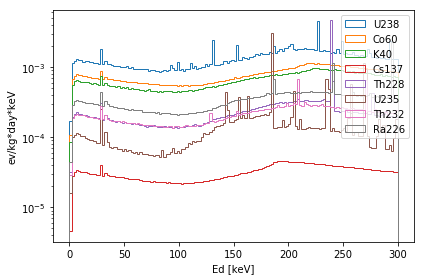

In [105]:
#isotope_array = ["U238", "Th232", "Th228", 
                 #"Ra226", 
                 #"K40", "Cs137", "U235"]
components = ["PmtTpc"]
###plot spectrum per component 
def plot_spectrum(data, min,max, bins, isotope, time):
    time_weights = [(1/time)*(864/(40*12))]*len(data)
    plt.hist(data.Ed, bins = bins, range = (min, max), weights = time_weights, histtype = 'step', label = isotope)
    plt.ylabel('ev/kg*day*keV')
    plt.xlabel('Ed [keV]')
    plt.yscale('log')
    plt.tight_layout()
    plt.legend()
    
for component in components:
    print("working on:" , component)
    p = get_parameters(component)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        data, frac, material = get_data(isotope, component)
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #later on with the good function
        n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        if contamination > 0:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
        else:          
            print("no contamination")
        
        plot_spectrum(data, 0, 300, 150, isotope, time) 
    plt.show()

In [ ]:
# plot spectrum per material 

def plot_total_contribution(bins, min_val, max_val ):
    conv = 3.15*1e7 #sec->year
    bins_ = bins 
    min_ = min_val
    max_ = max_val
    values = np.zeros(bins) 
    for component in components:
        print("working on:" , component)
        for i in range(0, len(isotope_array)):
            n =0
            isotope = isotope_array[i]
            data, frac, material = get_data(isotope, component)
            N_ = number_of_events(material)
            N = N_[isotope]
            b = select_typepri(data, isotope) #later on with the good function
            n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
            p = get_parameters(component)
            mass = p['mass']
            contamination = p[isotope] 
            if contamination > 0:
                contamination = p[isotope]/1000 
                time = n / (mass * contamination)
            else:          
                print("no contamination for ", isotope)
            time_weights = [1/time]*len(data)
            n, bins_plt, _ = plt.hist(data.Ed, bins = bins_, range = (min_, max_), weights = time_weights, 
                                      histtype = "step", label = ("%s %s"%(component, isotope)))            
            #plt.yscale("log") 
            values = values+n 
    return values, bins_plt


values, bins_plt = plot_total_contribution(300, 0, 500 )
plt.plot(bins_plt[:-1], values, "black", label = "tot")
plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.yscale("log")
plt.ylabel("rate")

plt.xlabel("Energy [keV]")
plt.title("ER from materials")
plt.show() 

working on: SS_InnerCryostatShell
working on: SS_InnerCryostatFlanges
working on: SS_InnerCryostat_bottomDome
working on: SS_AnodeRing
working on: Teflon_Pillar_
no contamination for  Co60
working on: SS_BellSideWall
working on: SS_BellSideWallBottomLip
working on: Copper_BottomPmtPlate


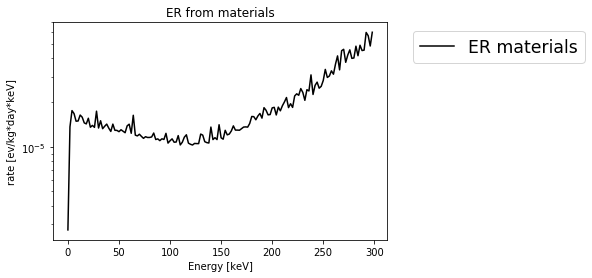

In [124]:
#plot the spectrum for bbf
components = ["SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "SS_AnodeRing",
             "Teflon_Pillar_",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "Copper_BottomPmtPlate" 
             ]
def plot_total_contribution(bins, min_val, max_val ):

    bins_ = bins 
    min_ = min_val
    max_ = max_val
    values = np.zeros(bins) 
    for component in components:
        print("working on:" , component)
        for i in range(0, len(isotope_array)):
            isotope = isotope_array[i]
            data, frac, material = get_data(isotope, component)
            N_ = number_of_events(material)
            N = N_[isotope]
            data = fv(data)
            b = select_typepri(isotope) #later on with the good function
            n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
            p = get_parameters(component)
            mass = p['mass']
            contamination = p[isotope] 
            if contamination > 0:
                contamination = p[isotope]/1000 
                time = n / (mass * contamination)
            else:          
                print("no contamination for ", isotope)
            time_weights = [1/time]*len(data)
            m, bins_plt, = np.histogram(data.Ed, bins = bins_, range = (min_, max_), weights = time_weights)            
            plt.yscale("log")              
            values = values + m
    return values, bins_plt

#conv = 3.15*1e7 
conv = 864/(40*12)
values, bins_plt = plot_total_contribution(150, 0, 300 ) #bins, min, max

for i in range (0, len(values)):
    values[i] = values[i]*conv
plt.plot(bins_plt[:-1], values, "black", label = "ER materials")
plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-large')
plt.yscale("log")
plt.ylabel("rate [ev/kg*day*keV]")

plt.xlabel("Energy [keV]")
plt.title("ER from materials")
plt.show() 

In [127]:
map_ = values.tolist()

import time
import json

data_map={'description': 'Preliminary background from materials .\nRate is in kg/d/KeV.\n \nArianna Rocchetti, Dec.2019\n', 
          'name': 'Spectrum',
          'timestamp': time.time(),
          'coordinate_system': [['E', [0, 200, 200]]],
          'map': map_}
with open('spectrum.json', 'w') as fp:
    json.dump(data_map, fp)

In [121]:
with open('spectrum.json') as json_file:
    dt = json.load(json_file)

In [122]:
dt

{'description': 'InnerCryostat bck from materials .\nRate is in kg/d/KeV.\nExtracted from HDF5 MC sample Pb214 files for XENON1T. \nJacques Pienaar, December 5 2019\n',
 'name': 'InnerCryoSpectrum',
 'timestamp': 1576796699.7299554,
 'coordinate_system': [['E', [0, 200, 200]]],
 'map': [8.072159351033585e-08,
  9.394560882943524e-08,
  2.85444736447502e-06,
  1.4279599032628121e-06,
  5.454906319128497e-08,
  4.821255585088319e-08,
  1.5467908207477002e-06,
  1.5086814967731478e-06,
  2.3702247998503408e-07,
  2.0318148537157915e-07,
  1.4319071876630243e-06,
  1.3003615063781065e-07,
  2.1599225021195668e-07,
  1.2425064393570466e-07,
  2.8114693146879466e-06,
  3.250903765945266e-08,
  1.7093360090449636e-06,
  6.501807531890532e-08,
  9.394560882943524e-08,
  1.4969252629819295e-06,
  1.6722869372277765e-07,
  6.501807531890532e-08,
  1.5536783287263977e-06,
  2.757758194670518e-07,
  1.5262717680793876e-07,
  2.275632636161686e-07,
  4.620140352110349e-07,
  2.2398175946724587e-07,

In [ ]:
#print a table with the contaminations values
components = ["OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "OuterCryostatReflector",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "PmtTpc",
              "Copper_TopRing",
              "Copper_LowerRing",
              "Teflon_Pillar_",
              "SS_Electrodes",
              "Teflon_BottomTPC",
              "Teflon_TPC_Sliding",
              "Teflon_TPC_Fixed",
              "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Top_PTFE_Frame",
              "Copper_BottomPmtPlate",
             "Copper_TopPmtPlate"]


isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]
def only_cont(component, m_fv): 
    p = get_parameters(component)
    screen_id = (p["ids"])
    total_str = ("|%s" %screen_id)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]
        contamination = p[isotope]
        if (contamination == 0):
            str_ = ("|<color #ed1c24>no contamination value</color>")
        else:
            str_ = ("|%2.2f  +- %2.2f" %(contamination, error_cont))
        total_str = total_str  + str_ 
               
    print("|" + component + total_str + "|")

def print_cont(m_fv):
    print("^material ^ screening_id ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^", )
    for component in components:
        only_cont(component, m_fv)

print_cont(m_fv)     

In [ ]:
def print_component(component):
    isotope = "Ra226"
    #return the correct root file to load according to the component
    df = pd.DataFrame()
    if component == "OuterCryostatShell":
        material = "SS_OuterCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        df = data
        print_volume(df)
    elif component == "OuterCryostat_Elongation":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        df = elongation
        print_volume(df)
    elif component == "OuterCryostat_flanges":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        flanges = pd.concat([flange1, flange2, flange3])
        df = flanges
        print_volume(df)
    elif component == "SS_InnerCryostatShell":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        
        df = shell_in
        print_volume(df)
    elif component == "SS_InnerCryostatFlanges":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        
        df = flanges_in
        print_volume(df)
    elif component == "SS_InnerCryostat_bottomDome":
        material = "SS_InnerCryostat" 
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        df = elongation_in
        print_volume(df)
        
    elif component == "SS_BellSideWall":
        material = 'SS_BellSideWall'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        bottomLip, bellWall = divide_bellWall(data)
        df = bellWall
        print_volume(df)
        
    elif component == "SS_BellSideWallBottomLip":
        material = 'SS_BellSideWall'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        bottomLip, bellWall = divide_bellWall(data)
        df = bottomLip 
        print_volume(df)
  
    elif component == "Top_PTFE_Frame":
        material = 'SS_Teflon_TopElectrodesFrame'
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        print_volume(data)

    elif component ==  "Teflon_TPC_Sliding":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        print_volume(df)
    elif component ==  "Teflon_TPC_Fixed":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        print_volume(df)
    else:
        material = component
        rootfile = '/userdata/arocchetti/rootfiles/' +'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        print_volume(df)

        
        
for component in components:
    print_component(component)